Code for analyzing excitability-based modulation of info flow through LIF ntwks.

In [1]:
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic, GenericFlexible
from ntwk import LIFNtwk
from disp import raster, set_font_size

import _1A

In [2]:
SEED = Generic(NTWK=0, DRIVE=0, AB=0, PATH=0)

L = 2  # graph distance btwn A & B nrns
E_L_1 = -0.05  # hyperexcitable voltage (V)

N = 100  # num nrns
FRQ_UP = 429  # upstream stim freq (Hz)

Q = 0.1  # cxn density

GAMMA = 1.3141  # SF power-law coef

W_E_UP = 0.01  # upstream syn. weight
W_E_RCR = 0.00735  # rcr syn. weight

T_M = 0.05  # membrane time const (s)
E_L = -0.068  # membrane leak potential (V)
V_TH = -0.036  # spike threshold (V)
V_RESET = -0.068  # reset potential (V)
T_R = 0.002  # refrac per. (s)

E_E = 0  # exc syn. rev. potential (V)
T_E = 0.002  # exc syn time const (s)

DUR = 60  # smln dur
T_START = 0.5  # analysis start time
DT = 0.0005  # smln time step


# derived grouped params

## sf ntwk
P_SF = GenericFlexible(
    # ntwk
    gamma=GAMMA, n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_rcr=W_E_RCR, w_e_up=W_E_UP,
    
    # input & smln
    frq_up=FRQ_UP,
    dt=DT, dur=DUR, t_start=T_START, seed=SEED)

# Check EPSP induced by excitatory cxn weight

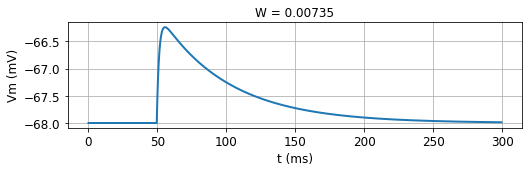

In [3]:
# skip
ntwk_epsp = LIFNtwk(
    t_m=np.array([T_M]),
    e_l=np.array([E_L]),
    v_th=np.array([V_TH]),
    v_reset=np.array([V_RESET]),
    t_r=np.array([T_R]),
    es_syn={'E': E_E},
    ts_syn={'E': T_E},
    ws_rcr={'E': np.array([[0.]])},
    ws_up={'E': np.array([[W_E_RCR]])})

t = np.arange(0, 0.3, DT)
spks_up = np.zeros((len(t), 1))
spks_up[int(0.05/DT), 0] = 1

rsp = ntwk_epsp.run(spks_up=spks_up, dt=DT)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5/3), tight_layout=True)
ax.plot(1000 * t, 1000 * rsp.vs[:, 0], lw=2)
ax.grid()
ax.set_xlabel('t (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('W = {}'.format(W_E_RCR))
set_font_size(ax, 12)

# Show shortest path length distributions for different N in SF ntwk

In [ ]:
# ...

# Test baseline ntwk

## Make SF ntwk and random EPSP drive

In [4]:
# make ntwk
STORE = GenericFlexible()
ntwk_0 = _1A.sf_ntwk(P_SF, STORE)[0]

# make frozen noise stim
np.random.seed(P_SF.seed)

t = np.arange(0, P_SF.dur, P_SF.dt)
spks_up = np.random.poisson(P_SF.frq_up * P_SF.dt, (len(t), P_SF.n))

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


## Run SF ntwk

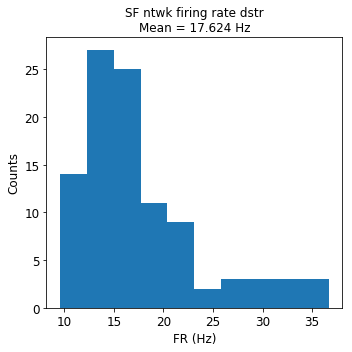

In [7]:
# drive sf ntwk
rsp_0 = ntwk_0.run(spks_up, P_SF.dt)

# plot firing rates
t_mask = (P_SF.t_start <= rsp_0.ts)
fr_0 = rsp_0.spks[t_mask, :].sum(0) / (P_SF.dur - P_SF.t_start)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ax.hist(fr_0)
ax.set_xlabel('FR (Hz)')
ax.set_ylabel('Counts')
ax.set_title('SF ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_0.mean()))

set_font_size(ax, 12)

## Make and run equiv unconnected ntwk

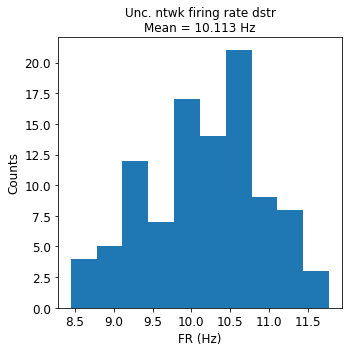

In [6]:
# make equiv. unc ntwk
ntwk_unc = deepcopy(ntwk_0)
ntwk_unc.ws_rcr['E'][:] = 0

# drive unc ntwk
rsp_unc = ntwk_unc.run(spks_up, P_SF.dt)

# plot firing rates
t_mask = (P_SF.t_start <= rsp_unc.ts)
fr_unc = rsp_unc.spks[t_mask, :].sum(0) / (P_SF.dur - P_SF.t_start)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ax.hist(fr_unc)
ax.set_xlabel('FR (Hz)')
ax.set_ylabel('Counts')
ax.set_title('Unc. ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_unc.mean()))

set_font_size(ax, 12)

# Run example smln

## Generate and run random SF ntwk

In [ ]:
# ...

# plot FR dstr

## Select cells A and B separated by L cxns

In [ ]:
# ...

## Choose shortest path btwn A and B

In [ ]:
# ...

## Create and run SF ntwk copy with A-->B path hyperexcitable

In [ ]:
# ...

# plot FR dstr

## Define MI func

In [ ]:
def bin_spks(t, spks, del_t):
    pass

def mi(idx_a, idx_b, spks_binned, d):
    pass

## Test MI comparison with SF ntwk copy w/ added A-->B direct cxn

In [ ]:
def test_mi_comparison():
    return test_vars

## Compute MI for A-->B w/ & w/o hyperexcitable path

In [ ]:
# ...

## Compute A-->B corrs w/ & w/o hyperexcitable path

In [ ]:
# ...

## Plot hyperexcitability-determined changes in A-->B MI & corr

In [ ]:
# ...